In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import pybedtools
import numpy as np

In [3]:
def filter_cent_dist(cent):
    #print(cent)
    if isinstance(cent, float): # for hg19
        return False
    if 'N/A' in cent:
        return False
    else:
        cent = map(int, cent.split(':'))
        return any([i < 1e6 for i in cent])

In [4]:
def filter_cent_dist_indel(cent):
    if isinstance(cent, float): # for hg19
        return False
    if 'N/A' in cent:
        return False
    else:
        cent = map(int, cent.split(','))
        return any([i < 1e6 for i in cent])

In [5]:
def remove_alt_path(test_bed):
    test_bed = test_bed.loc[~((test_bed['#chrom_contig1'].str.contains("[#<>]"))|
                          (test_bed['#chrom_contig1'].str.contains("HG"))), :]
    test_bed = test_bed.loc[~((test_bed['chrom_contig2'].str.contains("[#<>]"))),:]
    test_bed_bnd = test_bed.loc[(test_bed['sv_type']=='bnd') & (test_bed['#chrom_contig1']==test_bed['chrom_contig2']), :].copy()
    test_bed_indel = test_bed.loc[(test_bed['sv_type']=='indel'), :].copy()
    test_bed_bnd = test_bed_bnd.loc[~test_bed_bnd['VNTR_hits'].str.contains("True"), :]
    test_bed_indel.loc[test_bed_indel.VNTR_hits.isna(), 'VNTR_hits'] = 'False'
    test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'
    test_bed_indel = test_bed_indel.loc[~test_bed_indel.loc[:, 'VNTR_hits'], :]
    test_bed_bnd = test_bed_bnd.loc[~test_bed_bnd['Centromere_dist'].map(filter_cent_dist), :]
    test_bed_bnd['counts'] = test_bed_bnd.iloc[:, -4].str.split(',').map(len)
    test_bed_indel['counts'] = test_bed_indel.iloc[:, -4].str.split(',').map(len)
    test_bed_indel = test_bed_indel.loc[~test_bed_indel['Centromere_dist'].map(filter_cent_dist_indel), :]
    return test_bed_bnd, test_bed_indel

/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/1797600841.py:2: DtypeWarning: Columns (2,6,7,8,10,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    1203
bnd       794
Name: sv_type, dtype: int64


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    266
bnd       63
Name: sv_type, dtype: int64


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/1797600841.py:2: DtypeWarning: Columns (2,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    27156
bnd       1111
Name: sv_type, dtype: int64


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/1797600841.py:2: DtypeWarning: Columns (2,6,7,8,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


indel    7585
bnd       235
Name: sv_type, dtype: int64


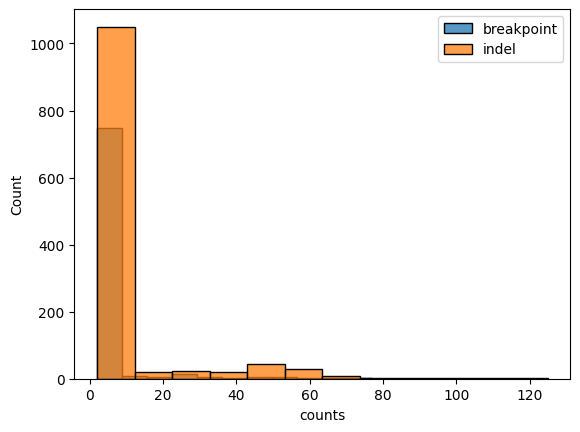

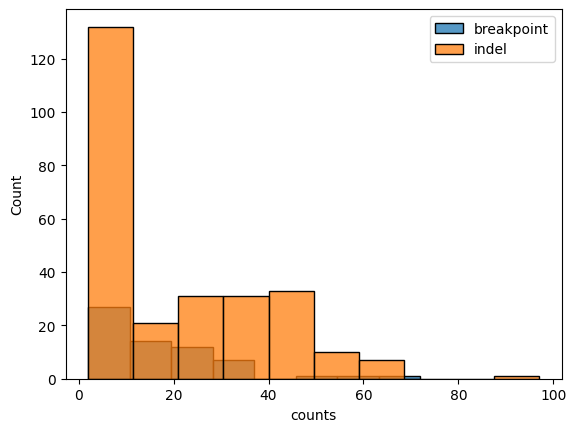

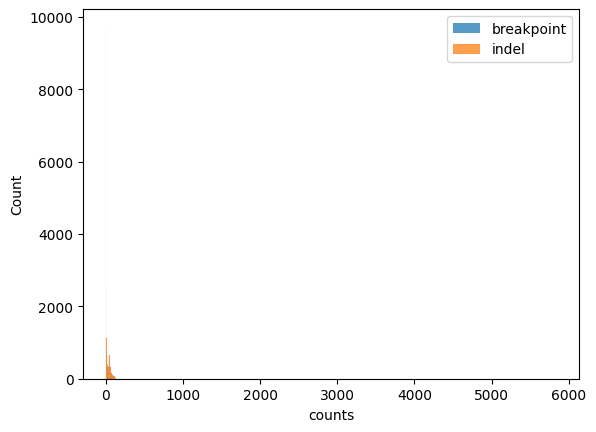

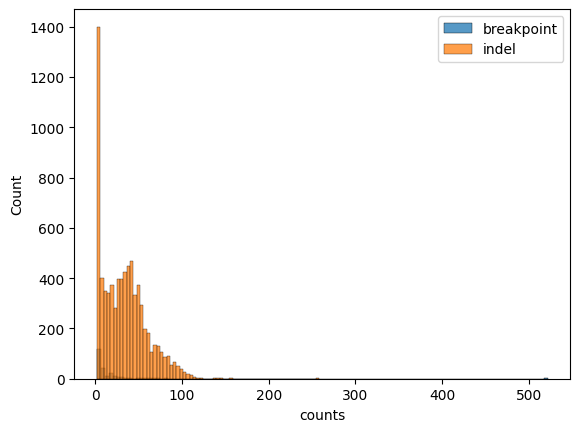

In [6]:
for test_bed_file in glob("chm13*harmonize/*COLO*harmonize*bed.gz"):
    test_bed = pd.read_table(test_bed_file)
    test_bed_bnd, test_bed_indel = remove_alt_path(test_bed)
    test_bed_clean = pd.concat([test_bed_bnd.loc[:, ['#chrom_contig1', 'start1', 'start2', 'counts', 'sv_type']], 
    test_bed_indel.loc[:, ['#chrom_contig1', 'start1', 'end1', 'counts', 'sv_type']].rename({"end1": "start2"}, axis='columns')], axis=0)
    #print(test_bed_clean.head())
    print(test_bed_clean.sv_type.value_counts())
    plt.figure()
    sns.histplot(test_bed_bnd['counts'], label='breakpoint')
    sns.histplot(test_bed_indel['counts'], label='indel')
    plt.legend()

In [7]:
glob("*harmonize/*COLO*harmonize*bed.gz")

['grch37linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch37linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'chm13graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'chm13graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch38graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch38graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'chm13linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'chm13linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch38linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch38linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch37graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz',
 'grch37graph_harmonize/COLO829_mapq5_m

In [8]:
#truthset_dict = {"grch38": ['output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.PB.bed', 'output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.ONT.bed'],
#                 "chm13":['output/truthset.colo829.out.chm13v2.crossmap.vcf.PB.bed', 'output/truthset.colo829.out.chm13v2.crossmap.vcf.ONT.bed'], 
#                 "grch37": ['output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.PB.bed', 'output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.ONT.bed']}

truthset_dict = {"grch38": ['output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.all.bed', 'output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.all.bed'],
                 "chm13":['output/truthset.colo829.out.chm13v2.crossmap.vcf.all.bed', 'output/truthset.colo829.out.chm13v2.crossmap.vcf.all.bed'], 
                 "grch37": ['output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.all.bed', 'output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.all.bed']}

In [9]:
truthset_dict

{'grch38': ['output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.all.bed',
  'output/truthset_somaticSVs_COLO829_hg38_sort.vcf.gz.all.bed'],
 'chm13': ['output/truthset.colo829.out.chm13v2.crossmap.vcf.all.bed',
  'output/truthset.colo829.out.chm13v2.crossmap.vcf.all.bed'],
 'grch37': ['output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.all.bed',
  'output/truthset_somaticSVs_COLO829_hg19_sort.vcf.gz.all.bed']}

In [10]:
import os
colo_bench_results = []

for test_bed_file in glob("*harmonize/*COLO*harmonize*bed.gz"):
    print(test_bed_file)
    genome = os.path.dirname(test_bed_file).replace("linear_harmonize", "").replace("graph_harmonize", "")
    gold = truthset_dict[genome]

    test_bed = pd.read_table(test_bed_file)
    test_bed_bnd, test_bed_indel = remove_alt_path(test_bed)
    test_bed_clean = pd.concat([test_bed_bnd.loc[:, ['#chrom_contig1', 'start1', 'start2', 'counts', 'sv_type']], 
                                 test_bed_indel.loc[:, ['#chrom_contig1', 'start1', 'end1', 'counts', 'sv_type']].rename({"end1": "start2"}, axis='columns')], axis=0)
    print(test_bed_clean.head())
    #print(test_bed_clean.head())
    print(test_bed_clean.sv_type.value_counts())

    if 'ONT' in test_bed_file:
        gold = pd.read_table(gold[1], header=None)
        if 'grch37' not in test_bed_file:
            gold.iloc[:, 0] = gold.iloc[:, 0].map(lambda x: "chr%s" % x)
        gold = gold.iloc[:, [0, 1, 2, 4]]
        #print(gold.iloc[:, 2] - gold.iloc[:, 1])
    else:
        gold = pd.read_table(gold[0], header=None)
        if 'grch37' not in test_bed_file:
            gold.iloc[:, 0] = gold.iloc[:, 0].map(lambda x: "chr%s" % x)
        gold = gold.iloc[:, [0, 1, 2, 4]]
        #print(gold.iloc[:, 2] - gold.iloc[:, 1])

    #NOTE: do not reorder start and end
    #  due to potential inversion and duplication

    #start = test_bed_clean.apply(lambda x: x[2] if int(x[1]) > int(x[2]) else x[1], axis=1)
    #end = test_bed_clean.apply(lambda x: x[1] if int(x[1]) > int(x[2]) else x[2], axis=1)
    #test_bed_clean.loc[:, 'start1'] = start
    #test_bed_clean.loc[:, 'start2'] = end
    print(pd.crosstab(test_bed_clean.start2.astype(int) - test_bed_clean.start1.astype(int) > 0, test_bed_clean.sv_type))

    test_bed_clean = test_bed_clean.loc[test_bed_clean.start2.astype(int) - test_bed_clean.start1.astype(int) >= 50, :]
    our_sv = pybedtools.BedTool.from_dataframe(test_bed_clean)
    our_sv_df = our_sv.sort().merge(d=200, c=4, o='sum').to_dataframe()
    our_sv_filter = pybedtools.BedTool.from_dataframe(our_sv_df.loc[our_sv_df.iloc[:, -1] >= 10, :])
    gold_sv = pybedtools.BedTool.from_dataframe(gold)
    colo_bench_results.append([test_bed_file, our_sv_filter.sort().merge(d=200).count(), gold_sv.sort().merge(d=200).count(), gold_sv.sort().merge(d=200).intersect(our_sv_filter.sort().merge(d=200), wa=True, u=True).count(), our_sv_filter.sort().merge().intersect(gold_sv.sort().merge(d=200), wa=True, u=True).count()])
    #colo_bench_results.append([test_bed_file, our_sv.sort().merge(d=200).count(), gold_sv.sort().merge(d=200).count(), gold_sv.sort().merge().intersect(our_sv, wa=True, u=True).count(), gold_sv.intersect(our_sv, wa=True, u=True).count(), our_sv.sort().merge().intersect(gold_sv, wa=True, u=True).count()])

grch37linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/2400982559.py:9: DtypeWarning: Columns (2,6,7,8,10,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


   #chrom_contig1   start1     start2  counts sv_type
0               1   237987     521571       2     bnd
14              1  5619577  189164955       2     bnd
15              1  7034666   59413669       2     bnd
16              1  7280371    5565294       2     bnd
17              1  9403841    9319335      43     bnd
indel    50982
bnd       2341
Name: sv_type, dtype: int64
sv_type   bnd  indel
row_0               
False    1296      0
True     1045  50982
grch37linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/2400982559.py:9: DtypeWarning: Columns (2,6,7,8,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


   #chrom_contig1    start1     start2  counts sv_type
4               1   9403841    9319336      19     bnd
5               1  13052945   12928507       3     bnd
7               1  16893861  148250865       3     bnd
9               1  16955570   16801044       2     bnd
10              1  17051749  234912189      36     bnd
indel    20404
bnd        847
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    418      0
True     429  20404
chm13graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/2400982559.py:9: DtypeWarning: Columns (2,6,7,8,10,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


     #chrom_contig1    start1     start2  counts sv_type
1365           chr1   5081916  188541389       2     bnd
1366           chr1   6503252   58826437       2     bnd
1367           chr1   6749639    5027653       2     bnd
1368           chr1   8878653    8793893      43     bnd
1369           chr1  10536441   10536428       2     bnd
indel    1203
bnd       794
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    470      0
True     324   1203
chm13graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


    #chrom_contig1     start1     start2  counts sv_type
797           chr1    8878653    8793894      19     bnd
804           chr1  145182888   15995880       2     bnd
810           chr1  207054642  207088231      14     bnd
811           chr1  223801230  223647746      26     bnd
847          chr10   82755870   82941765       4     bnd
indel    266
bnd       63
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False     27      0
True      36    266
grch38graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/2400982559.py:9: DtypeWarning: Columns (2,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


     #chrom_contig1    start1     start2  counts sv_type
2244           chr1   5559522  189195824       2     bnd
2245           chr1   6974606   58947994       2     bnd
2246           chr1   7220311    5505234       2     bnd
2247           chr1   9343782    9259276      43     bnd
2248           chr1  10995197   10995184       2     bnd
indel    2083
bnd       959
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    557      0
True     402   2083
grch38graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


     #chrom_contig1     start1     start2  counts sv_type
1001           chr1    9343782    9259277      19     bnd
1045           chr1  148705370  146313312       2     bnd
1046           chr1  207807883  207841476      14     bnd
1047           chr1  224612415  224458902      26     bnd
1119          chr10   81882047   82067935       4     bnd
indel    418
bnd      107
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False     41      0
True      66    418
chm13linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/2400982559.py:9: DtypeWarning: Columns (2,6,7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


   #chrom_contig1    start1     start2  counts sv_type
8            chr1   5081911  188541389       2     bnd
9            chr1   6503252   58826440       2     bnd
10           chr1   6749639    5027653       2     bnd
11           chr1   8878653    8793893      43     bnd
12           chr1  10536443   10536428       2     bnd
indel    27156
bnd       1111
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    619      0
True     492  27156
chm13linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/2400982559.py:9: DtypeWarning: Columns (2,6,7,8,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


  #chrom_contig1     start1     start2  counts sv_type
0           chr1    8878653    8793894      19     bnd
2           chr1   16396821  145169310      30     bnd
3           chr1   16670799  234167603       2     bnd
4           chr1   25104293   25165323       7     bnd
5           chr1  108344423  108481047       3     bnd
indel    7585
bnd       235
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    105      0
True     130   7585
grch38linear_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/2400982559.py:9: DtypeWarning: Columns (2,6,7,8,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


   #chrom_contig1   start1     start2  counts sv_type
0            chr1   268236     586191       2     bnd
22           chr1  5559517  189195824       2     bnd
23           chr1  6974606   58947997       2     bnd
24           chr1  7220311    5505234       2     bnd
25           chr1  9343782    9259276      43     bnd
indel    41216
bnd       1579
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    876      0
True     703  41216
grch38linear_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/2400982559.py:9: DtypeWarning: Columns (2,6,7,8,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


  #chrom_contig1    start1     start2  counts sv_type
1           chr1   9343782    9259277      19     bnd
3           chr1  16567366  149555788       2     bnd
4           chr1  16629075   16474549       2     bnd
5           chr1  16725254  234776442      43     bnd
6           chr1  16860372  234776442       4     bnd
indel    15027
bnd        443
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    193      0
True     250  15027
grch37graph_harmonize/COLO829_ONT_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/2400982559.py:9: DtypeWarning: Columns (2,6,7,8,10,16) have mixed types. Specify dtype option on import or set low_memory=False.
  test_bed = pd.read_table(test_bed_file)
/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


  #chrom_contig1    start1     start2  counts sv_type
0              1   5619583  189164955       2     bnd
1              1   7034666   59413666       2     bnd
2              1   7280371    5565294       2     bnd
3              1   9403841    9319335      43     bnd
4              1  11055254   11055241       2     bnd
indel    4202
bnd      1706
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    956      0
True     750   4202
grch37graph_harmonize/COLO829_mapq5_mlen50_support2_maplen2000_harmonized.bed.gz


/home/ubuntu/depmap_omics/sandbox/vcf2maf/tmp/ipykernel_25009/684429063.py:9: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test_bed_indel.loc[:, 'VNTR_hits'] = test_bed_indel.VNTR_hits == 'True'


  #chrom_contig1     start1     start2  counts sv_type
0              1    9403841    9319336      19     bnd
1              1   29878072   30028085      11     bnd
2              1   86005692  144852413       9     bnd
3              1  120630579  145080156      18     bnd
9              1  144526688  147835686       7     bnd
indel    669
bnd      510
Name: sv_type, dtype: int64
sv_type  bnd  indel
row_0              
False    255      0
True     255    669


In [11]:
final_table = pd.DataFrame(colo_bench_results)
final_table.columns = ['dataset_assembly', 'merged_our_sv_filter', 'merged_truthset', 'merged_true_positive_hits', 'all_hits']

In [12]:
final_table.loc[:, 'platform'] = np.where(final_table.dataset_assembly.str.contains("ONT"), "ONT", "HIFI")
final_table.loc[:, 'structure'] = np.where(final_table.dataset_assembly.str.contains("linear"), "linear", "graph")
final_table.loc[:, 'assembly'] = final_table.dataset_assembly.map(lambda x: os.path.dirname(x).replace("linear_harmonize", "").replace("graph_harmonize", ""))


In [13]:
final_table

,dataset_assembly,merged_our_sv_filter,merged_truthset,merged_true_positive_hits,all_hits,platform,structure,assembly
0,grch37linear_harmonize/COLO829_ONT_mapq5_mlen5...,5523,28,27,18,ONT,linear,grch37
1,grch37linear_harmonize/COLO829_mapq5_mlen50_su...,5453,28,23,22,HIFI,linear,grch37
2,chm13graph_harmonize/COLO829_ONT_mapq5_mlen50_...,60,27,26,18,ONT,graph,chm13
3,chm13graph_harmonize/COLO829_mapq5_mlen50_supp...,91,27,22,22,HIFI,graph,chm13
4,grch38graph_harmonize/COLO829_ONT_mapq5_mlen50...,212,28,27,18,ONT,graph,grch38
5,grch38graph_harmonize/COLO829_mapq5_mlen50_sup...,127,28,22,22,HIFI,graph,grch38
6,chm13linear_harmonize/COLO829_ONT_mapq5_mlen50...,3682,27,26,17,ONT,linear,chm13
7,chm13linear_harmonize/COLO829_mapq5_mlen50_sup...,2667,27,22,21,HIFI,linear,chm13
8,grch38linear_harmonize/COLO829_ONT_mapq5_mlen5...,5063,28,27,18,ONT,linear,grch38
9,grch38linear_harmonize/COLO829_mapq5_mlen50_su...,3905,28,24,22,HIFI,linear,grch38


In [14]:
final_table.to_csv("COLO829_tumor_only_evaluation_across_assembly.csv")

In [15]:
%pwd

'/home/ubuntu/pangenome/pangenome_sv_benchmarking/2b.tumor_only_somatic_evaluation'

In [16]:
from plotnine import *

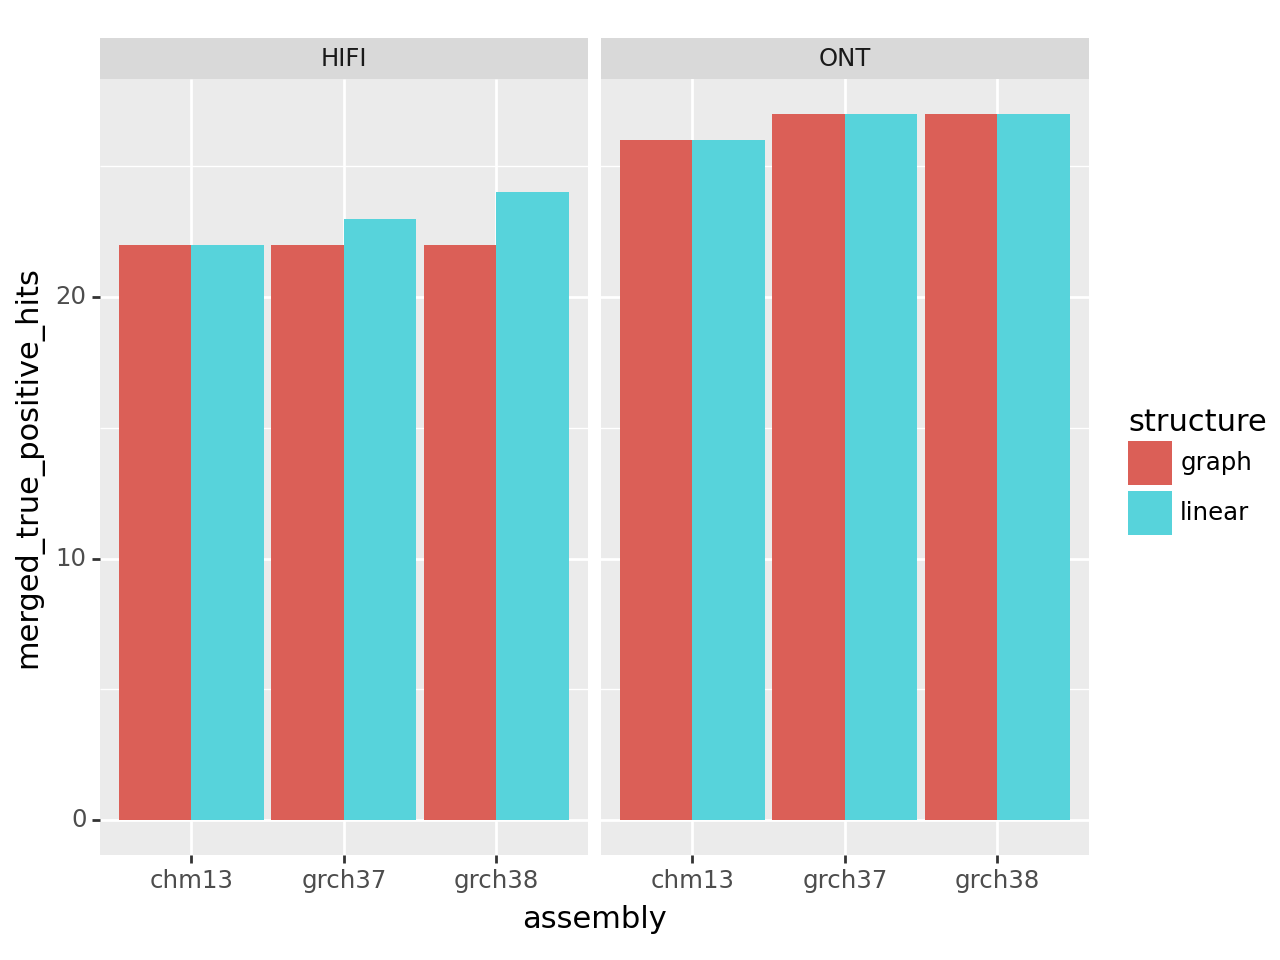

<Figure Size: (640 x 480)>

In [17]:
(ggplot(final_table, aes('assembly', 'merged_true_positive_hits', fill='structure'))
 + geom_col(position='dodge', width=.95) + facet_wrap("platform"))